In [1]:
# Import necessary libraries
from sklearn.datasets import fetch_lfw_people
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure

In [2]:
# Fetch LFW dataset with minimum faces per person = 40
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=0.4)

In [3]:
print(f"Actual shape of the image: {lfw_people.images.shape[1:]}")

Actual shape of the image: (50, 37)


In [4]:
# Storing the data
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
print(X.shape)

(1777, 50, 37)


In [5]:
def get_pixel(img, center, x, y):
	new_value = 0
	try:
		if img[x][y] >= center:
			new_value = 1
	except:
		pass

	return new_value

# Function for calculating LBP
def lbp_calculated_pixel(img, x, y):

	center = img[x][y]
	val_ar = []

	# top_left
	val_ar.append(get_pixel(img, center, x-1, y-1))
	# top
	val_ar.append(get_pixel(img, center, x-1, y))
	# top_right
	val_ar.append(get_pixel(img, center, x-1, y+1))
	# right
	val_ar.append(get_pixel(img, center, x, y+1))
	# bottom_right
	val_ar.append(get_pixel(img, center, x+1, y+1))
	# bottom
	val_ar.append(get_pixel(img, center, x+1, y))
	# bottom_left
	val_ar.append(get_pixel(img, center, x+1, y-1))
	# left
	val_ar.append(get_pixel(img, center, x, y-1))
	# Now, we need to convert binary values to decimal
	power_val = [1, 2, 4, 8, 16, 32, 64, 128]
	val = 0

	for i in range(len(val_ar)):
		val += val_ar[i] * power_val[i]

	return val

LBP Features : (1510, 1850)


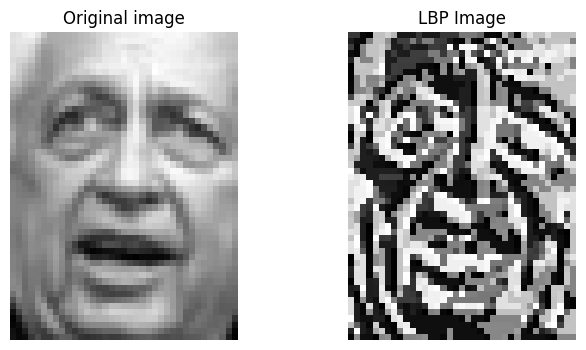

In [6]:
height, width = X[0].shape

# We use this new img_lbp as extracted features
lbp_features = np.zeros((X.shape[0], height, width),np.uint8)

for k in range(X.shape[0]):
	for i in range(0, height):
		for j in range(0, width):
			lbp_features[k,i, j] = lbp_calculated_pixel(X[k], i, j)

X_lbp = np.array(lbp_features)
X_lbp=X_lbp.reshape(1777,1850)
y = lfw_people.target
X_train, X_test, y_train, y_test = train_test_split(X_lbp, y, test_size=0.15,stratify=y, random_state=42)
print("LBP Features :",X_train.shape)

# Visualising LBF image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X[0], cmap=plt.cm.gray)
ax1.set_title('Original image')

ax2.axis('off')
ax2.imshow((X_lbp[0].reshape(50,37)).astype(np.uint8), cmap=plt.cm.gray)
ax2.set_title('LBP Image')
plt.show()

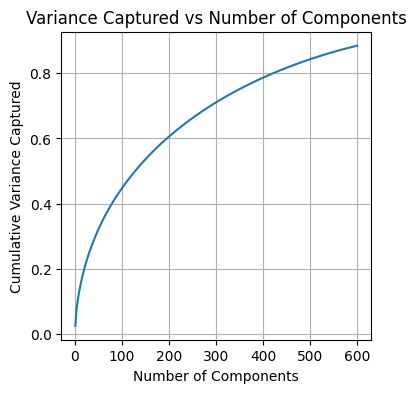

In [7]:
# # Applying PCA on LBP features
pca = PCA(random_state=1,n_components=600)
X_train1 = pca.fit_transform(X_train)
X_test1 = pca.transform(X_test)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plotting variance captured vs components
plt.figure(figsize=(4, 4))
plt.plot(range(1, pca.n_components_ + 1), cumulative_variance_ratio, linestyle='-')
plt.title('Variance Captured vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Captured')
plt.grid(True)
plt.show()

Linear Kernel Accuracy : 0.7116104868913857


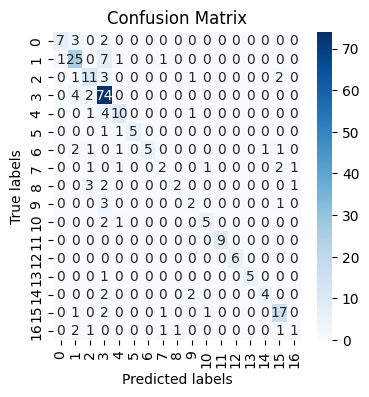

In [8]:
## Linear Kernel SVM
svm = SVC(kernel='linear')
svm.fit(X_train1, y_train)
y_pred = svm.predict(X_test1)
print("Linear Kernel Accuracy :",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Best parameters for Poly Kernel :  {'degree': 2, 'gamma': 0.001}
Poly Kernel Accuracy :  0.4419475655430712


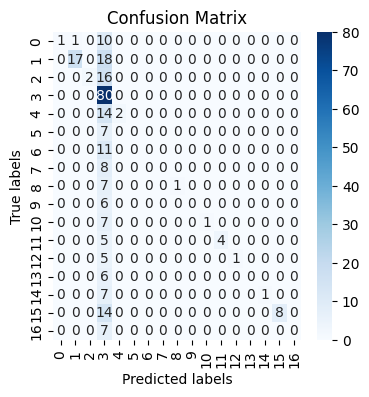

In [9]:
# Polynomial Kernel SVM
param_grid = {
              'degree': [2,3,4],
              'gamma': np.logspace(-3,2,4)}
svm = SVC(kernel='poly',degree=2)
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train1, y_train)
best_params = grid_search.best_params_
print("Best parameters for Poly Kernel : ", best_params)
y_pred = grid_search.best_estimator_.predict(X_test1)
print("Poly Kernel Accuracy : ",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Best parameters for RBF Kernel :  {'C': 464.15888336127773, 'gamma': 1e-09}
RBF Kernel Accuracy :  0.7078651685393258


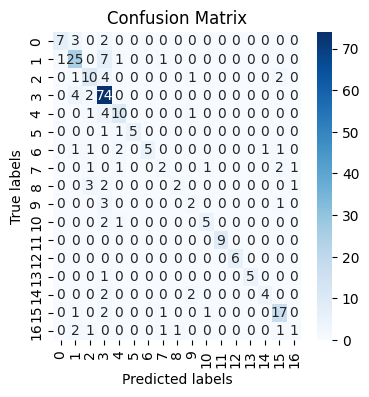

In [11]:
# RBF Kernel SVM
param_grid = {
              'C': np.logspace(0,4,4),
              'gamma': np.logspace(-9,-1,4)}
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train1, y_train)
best_params = grid_search.best_params_
print("Best parameters for RBF Kernel : ", best_params)
y_pred = grid_search.best_estimator_.predict(X_test1)
print("RBF Kernel Accuracy : ", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()